In [1]:
import heist
import helpers
import torch.distributions
import torch
import torch.nn as nn


import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math
from IPython.display import Image, display


from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv

%load_ext autoreload
%autoreload 2

In [2]:
class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations

        # Handle edge case: input is not a tensor
        if not isinstance(input, torch.Tensor):
            input = torch.tensor(input, dtype=torch.float32)


        # Check the shape of the input and reshape if necessary
        if input.shape == torch.Size([1, 3, 64, 64]):
            input = input.squeeze(0)  # Remove the batch dimension
        if input.shape == torch.Size([3, 64, 64]):
            input = input.permute(1, 2, 0)  # Switch dimensions to (64, 64, 3)


        # Handle edge case: empty layer_paths
        if not layer_paths:
            output = self.model(input)
            return output, self.activations

        # Register hooks for each layer path
        for path in layer_paths:
            try:
                self.register_hook_by_path(path, path.replace('.', '_'))
            except AttributeError:
                print(f"Warning: Layer '{path}' not found in the model. Skipping hook registration.")

        # Add batch dimension if missing
        if input.dim() == 3:
            input = input.unsqueeze(0)

        # Run the model with the registered hooks
        output = self.model(input)

        return output, self.activations
    
def create_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "gem": [],
        "blue_key": [],
        "green_key": [],
        "red_key": [],
        "blue_lock": [],
        "green_lock": [],
        "red_lock": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset




In [179]:
#Create dataset for probes
dataset = heist.create_classified_dataset(num_samples_per_category=400)


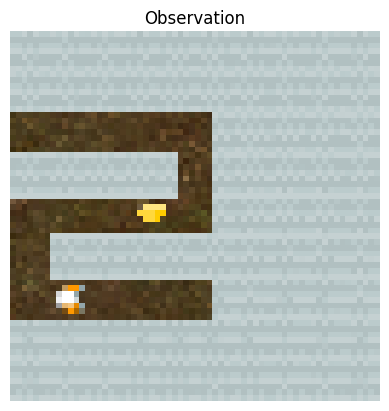

In [180]:
helpers.plot_single_observation(dataset["blue_key"][0])

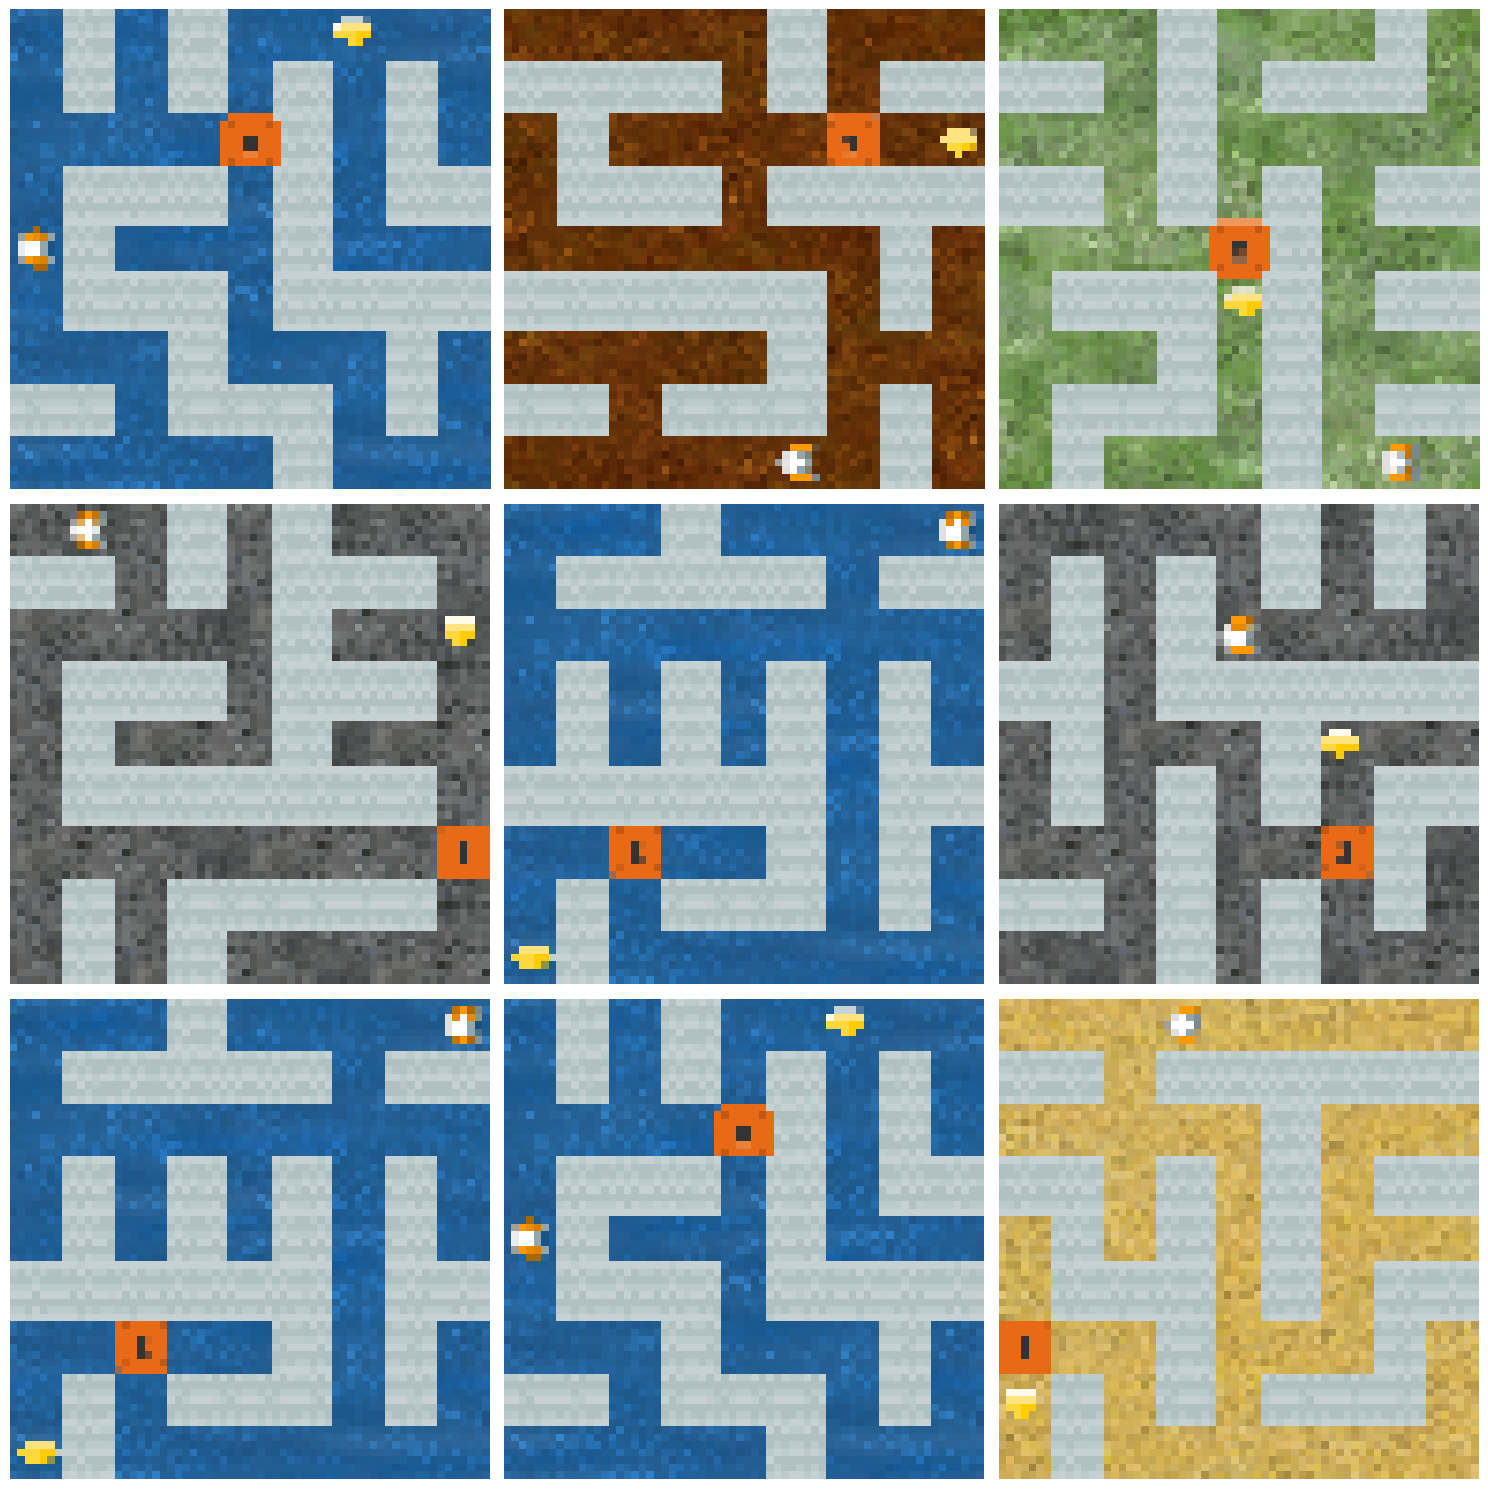

In [181]:
import matplotlib.pyplot as plt
import itertools

# Visualize dataset for probes
# Assuming 'dataset' is your data structure and it contains at least 15 images under the "blue_key" key
images = dataset["red_lock"]  # Access the list of images
random.shuffle(images)
n_samples = 9  # Number of samples to display

# Create a figure with subplots in a 5x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the first 15 images (ensuring there are at least 15)
for idx, img in enumerate(images[:n_samples]):
    i, j = divmod(idx, 3)  # Calculate subplot grid indices
    axs[i, j].imshow(img)  # Display the image on the corresponding subplot
    axs[i, j].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot


In [182]:
# Create classified dataset

# Load the model
model = load_model()

layer_names = [name for name, _ in model.named_modules() if isinstance(_, nn.Module)]
layer_names = layer_names[1:len(layer_names)]
print(layer_names)

# Create activation dataset, which is a dictionary with labels "gem", and activations as a list
# objective name, sample number, layer, stored as tuple
activation_dataset = create_activation_dataset(dataset, model, layer_names)

['conv_seqs', 'conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.conv', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.conv', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc', 'logits_fc', 'value_fc']


In [183]:
# Now we want to obtain the average activation vector from each objective label for the hidden layer.
# print(activation_dataset["gem"][2]['hidden_fc'][0])

objective_vectors = {}
for key in activation_dataset.keys():
    objective_vector = 0
    for i in range(len(activation_dataset[key])):
        objective_vector += activation_dataset[key][i]['hidden_fc'][0]
    objective_vectors[key] = objective_vector/len(activation_dataset[key])

In [3]:
@torch.no_grad()
def generate_action_with_steering(model, observation, steering_vector, is_procgen_env=False):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    
    # Define the steering hook function
    def steering_hook(module, input, output):
        # Add the steering vector to the output activations
        modified_output = output + steering_vector.unsqueeze(0)
        return modified_output

    # Register the steering hook to the 'hidden_fc' layer
    named_modules_dict = dict(model.named_modules())
    hidden_fc_layer = named_modules_dict['hidden_fc']
    steering_handle = hidden_fc_layer.register_forward_hook(steering_hook)

    # Forward pass with steering
    model_output = model(observation)

    # Remove the steering hook
    steering_handle.remove()

    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    probabilities = torch.softmax(logits, dim=-1)
    action = torch.multinomial(probabilities, 1).item()

    if is_procgen_env:
        return np.array([action])
    return action

def run_episode_with_steering_and_save_as_gif(env, model, steering_vector, filepath='../gifs/run.gif', save_gif=False, episode_timeout=200):
    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames = []
    count = 0

    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        action = generate_action_with_steering(model, observation, steering_vector, is_procgen_env=False)

        # Perform inference with the model one step
        observation, reward, done, info = env.step(action)
        total_reward += reward
        observations.append(observation)
        count += 1

        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)

    return total_reward, frames, observations

In [186]:

model = load_model()

# Create environment and load model

venv = heist.create_venv(1,0,0)

# obs = venv.reset()
# # Transpose the data to (height, width, channels)
# helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))

total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode.gif', save_gif=True, episode_timeout=100, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")


total_reward, frames2, observations2 = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode2.gif', save_gif=True, episode_timeout=100, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")

# Display an image file from local storage
# display(Image(filename='episode.gif'))
# display(Image(filename='episode2.gif'))
# helpers.plot_single_observation(observations[0].squeeze())
# helpers.plot_single_observation(observations2[0].squeeze())

Saved gif!
Episode finished with total reward: [0.]
Saved gif!
Episode finished with total reward: [0.]


In [187]:
# Run model through episode with steering
# Next step is to patch the objective vectors back into the network during a forward pass and see how they affect the network

# Define the weights for each objective (you can experiment with different values)
objective_weights = {
    "gem": 0,
    "blue_key": -4,
    "green_key": 0,
    "red_key": 0,
    "blue_lock": 0,
    "green_lock": 0,
    "red_lock": 0
}

# Create a linear combination of average activation vectors
steering_vector = sum(objective_weights[obj] * objective_vectors[obj] for obj in objective_vectors)

model = load_model()

# Create environment and load model

venv = heist.create_venv(1,0,0)

# obs = venv.reset()
# # Transpose the data to (height, width, channels)
# helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))
total_reward, frames, observations2 = helpers.run_episode_with_steering_and_save_as_gif(venv, model, steering_vector, filepath=f'episode_steering.gif', save_gif=True,  episode_timeout=100, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")

_ = venv.reset()



total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode.gif', save_gif=True,  episode_timeout=100, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")




# Display an image file from local storage
# display(Image(filename='episode_steering.gif'))
# display(Image(filename='episode.gif'))


Saved gif!
Episode finished with total reward: [0.]
Saved gif!
Episode finished with total reward: [0.]


In [189]:
# Display an image file from local storage
# display(Image(filename='episode_steering.gif'))
# display(Image(filename='episode.gif'))

In [4]:
def create_direction_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "top_left": [],
        "top_right": [],
        "bottom_left": [],
        "bottom_right": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset

model = helpers.load_model(model_path="../model_501_copper_wave.pt")
dataset = heist.create_direction_dataset(100)
layer_names = helpers.get_model_layer_names(model)
activation_dataset = create_direction_activation_dataset(dataset, model, layer_names)

In [5]:
direction_vectors = {}
for key in activation_dataset.keys():
    direction_vector = 0
    for i in range(len(activation_dataset[key])):
        direction_vector += activation_dataset[key][i]['hidden_fc'][0]
    direction_vectors[key] = direction_vector/len(activation_dataset[key])

In [10]:
# Run model through episode with steering
# Next step is to patch the objective vectors back into the network during a forward pass and see how they affect the network

# Define the weights for each objective (you can experiment with different values)
direction_weights = {
        "top_left": 10,
        "top_right": 0,
        "bottom_left": 0,
        "bottom_right": 0
    
}

# Create a linear combination of average activation vectors
steering_vector = sum(direction_weights[obj] * direction_vectors[obj] for obj in direction_vectors)

model = helpers.load_model(model_path="../model_501_copper_wave.pt")


# Create environment and load model

venv = heist.create_venv(1,1,1)

# obs = venv.reset()
# # Transpose the data to (height, width, channels)
# helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))
total_reward, frames, observations2 = helpers.run_episode_with_steering_and_save_as_gif(venv, model, steering_vector, filepath=f'episode_steering.gif', save_gif=True,  episode_timeout=200, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")

total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode.gif', save_gif=True,  episode_timeout=200, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")
_ = venv.reset()



# # Display an image file from local storage
# display(Image(filename='episode_steering.gif'))
# display(Image(filename='episode.gif'))


Saved gif!
Episode finished with total reward: [0.]
Episode finished with total reward: [10.]
